## Import Depedencies

In [1]:
import os
import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input

from tensorflow.keras.utils import to_categorical


## Collecting Data

In [24]:
cap = cv2.VideoCapture(0)

my_name = "Beni"
i = 0
while cap.isOpened():
    ret, frame = cap.read()
    
    if ret :
        cv2.imshow("Capture Photo", frame)
        cv2.imwrite("sample/Beni/%s_%04d.jpg" %  (my_name, i), frame)
        
        if cv2.waitKey(100) == ord('q') or i == 30:
            break
        i += 1    
cap.release()
cv2.destroyAllWindows()

In [25]:
cap.release()
cv2.destroyAllWindows()

## Read Image & Convert to Grayscale

In [4]:
def detect_face(img):
    img = img[40:230,60:190]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (50, 50))
    return img

In [5]:
def print_progress(val, val_len, folder, bar_size=20):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] (%d samples)\t label : %s \t\t" % (progr, val+1, folder), end="\r")

In [6]:
dataset_folder = "datasets/"

names = []
images = []
for folder in os.listdir(dataset_folder):
    files = os.listdir(os.path.join(dataset_folder, folder))[:150]
    if len(files) < 50 :
        continue
    for i, name in enumerate(files): 
        if name.find(".jpg") > -1 :
            img = cv2.imread(os.path.join(dataset_folder + folder, name))
            img = detect_face(img) 
            if img is not None :
                images.append(img)
                names.append(folder)

                print_progress(i, len(files), folder)


[####################] (92 samples)	 label : Alwan 		
[####################] (77 samples)	 label : Ariel_Sharon 		
[####################] (94 samples)	 label : Bapa 		
[####################] (99 samples)	 label : Beni 		
[####################] (150 samples)	 label : Colin_Powell 		
[####################] (121 samples)	 label : Donald_Rumsfeld 		
[####################] (82 samples)	 label : Eva_Fatmawati 		
[####################] (150 samples)	 label : George_W_Bush 		
[####################] (109 samples)	 label : Gerhard_Schroeder 		
[####################] (97 samples)	 label : Hugo_Chavez 		
[####################] (93 samples)	 label : Jacques_Chirac 		
[####################] (81 samples)	 label : Jean_Chretien 		
[####################] (92 samples)	 label : John_Ashcroft 		
[####################] (83 samples)	 label : Junichiro_Koizumi 		
[####################] (89 samples)	 label : Mama 		
[####################] (102 samples)	 label : Mang Edi 		
[####################] (80 samples)

In [7]:
labels = np.unique(names)

labels

array(['Alwan', 'Ariel_Sharon', 'Bapa', 'Beni', 'Colin_Powell',
       'Donald_Rumsfeld', 'Eva_Fatmawati', 'George_W_Bush',
       'Gerhard_Schroeder', 'Hugo_Chavez', 'Jacques_Chirac',
       'Jean_Chretien', 'John_Ashcroft', 'Junichiro_Koizumi', 'Mama',
       'Mang Edi', 'Serena_Williams', 'Tony_Blair'], dtype='<U17')

In [8]:
print("number of class :", len(labels))
print("number of samples :", len(names))

number of class : 18
number of samples : 1835


## Augmentation Image

In [9]:
def img_augmentation(img):
    h, w = img.shape
    center = (w // 2, h // 2)
    M_rot_5 = cv2.getRotationMatrix2D(center, 5, 1.0)
    M_rot_neg_5 = cv2.getRotationMatrix2D(center, -5, 1.0)
    M_rot_10 = cv2.getRotationMatrix2D(center, 10, 1.0)
    M_rot_neg_10 = cv2.getRotationMatrix2D(center, -10, 1.0)
    M_trans_3 = np.float32([[1, 0, 3], [0, 1, 0]])
    M_trans_neg_3 = np.float32([[1, 0, -3], [0, 1, 0]])
    M_trans_6 = np.float32([[1, 0, 6], [0, 1, 0]])
    M_trans_neg_6 = np.float32([[1, 0, -6], [0, 1, 0]])
    M_trans_y3 = np.float32([[1, 0, 0], [0, 1, 3]])
    M_trans_neg_y3 = np.float32([[1, 0, 0], [0, 1, -3]])
    M_trans_y6 = np.float32([[1, 0, 0], [0, 1, 6]])
    M_trans_neg_y6 = np.float32([[1, 0, 0], [0, 1, -6]])
    
    imgs = []
    imgs.append(cv2.warpAffine(img, M_rot_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.add(img, 10))
    imgs.append(cv2.add(img, 30))
    imgs.append(cv2.add(img, -10))
    imgs.append(cv2.add(img, -30)) 
    imgs.append(cv2.add(img, 15))
    imgs.append(cv2.add(img, 45))
    imgs.append(cv2.add(img, -15))
    imgs.append(cv2.add(img, -45))
    
    return imgs

## Test Augmentation Result

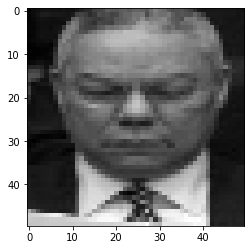

In [10]:
plt.imshow(images[500], cmap="gray")

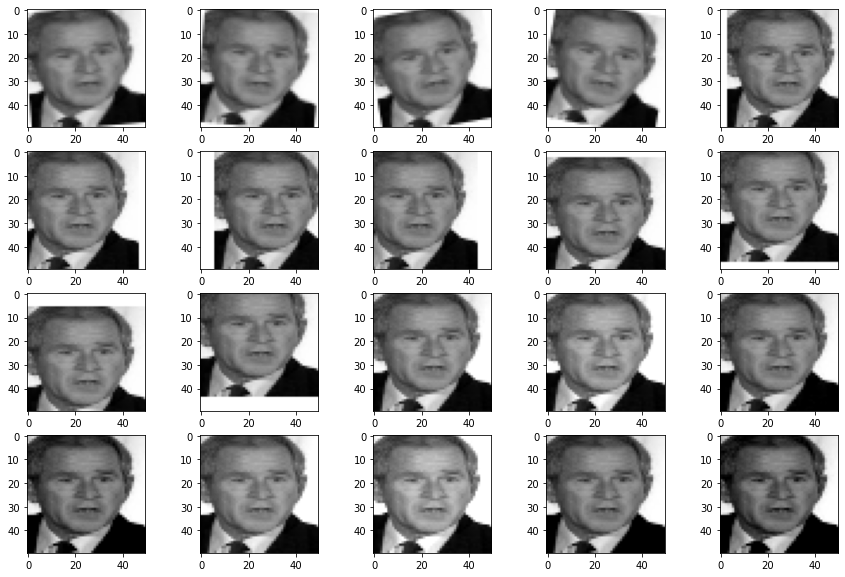

In [11]:
img_test = images[800]

augmented_image_test = img_augmentation(img_test)

plt.figure(figsize=(15,10))
for i, img in enumerate(augmented_image_test):
    plt.subplot(4,5,i+1)
    plt.imshow(img, cmap="gray")
plt.show()

## Apply Augmentation to All Images

In [12]:
augmented_images = []
augmented_names = []
for i, img in enumerate(images):
    try :
        augmented_images.extend(img_augmentation(img))
        augmented_names.extend([names[i]] * 20)
    except :
        print(i)

## Total Augmentation Image

In [13]:
len(augmented_images), len(augmented_names)

(36700, 36700)

## Total Images Augmentation + Original

In [14]:
images.extend(augmented_images)
names.extend(augmented_names)

In [15]:
len(images), len(names)

(38535, 38535)

In [16]:
unique, counts = np.unique(names, return_counts = True)

for item in zip(unique, counts):
    print(item)

('Alwan', 1932)
('Ariel_Sharon', 1617)
('Bapa', 1974)
('Beni', 2079)
('Colin_Powell', 3150)
('Donald_Rumsfeld', 2541)
('Eva_Fatmawati', 1722)
('George_W_Bush', 3150)
('Gerhard_Schroeder', 2289)
('Hugo_Chavez', 2037)
('Jacques_Chirac', 1953)
('Jean_Chretien', 1701)
('John_Ashcroft', 1932)
('Junichiro_Koizumi', 1743)
('Mama', 1869)
('Mang Edi', 2142)
('Serena_Williams', 1680)
('Tony_Blair', 3024)


# Balancing Data

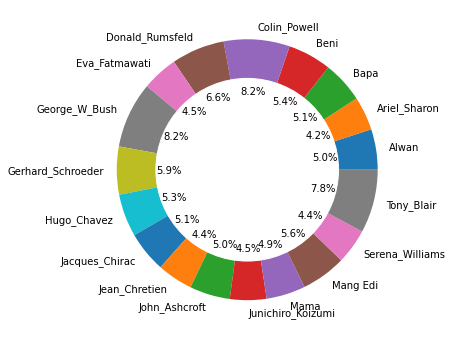

In [17]:
def print_data(label_distr, label_name):
    plt.figure(figsize=(12,6))

    my_circle = plt.Circle( (0,0), 0.7, color='white')
    plt.pie(label_distr, labels=label_name, autopct='%1.1f%%')
    plt.gcf().gca().add_artist(my_circle)
    plt.show()
    
unique = np.unique(names)
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

In [18]:
n = 1615

def randc(labels, l):
    return np.random.choice(np.where(np.array(labels) == l)[0], n, replace=False)

mask = np.hstack([randc(names, l) for l in np.unique(names)])

In [19]:
names = [names[m] for m in mask]
images = [images[m] for m in mask]

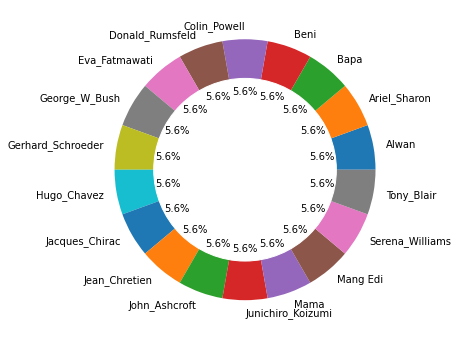

In [20]:
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

In [21]:
len(names)

29070

## Encoding Label & Categoricalization

In [22]:
le = LabelEncoder()

le.fit(names)

labels = le.classes_

name_vec = le.transform(names)

categorical_name_vec = to_categorical(name_vec)

In [23]:
print("number of class :", len(labels))
print(labels)

number of class : 18
['Alwan' 'Ariel_Sharon' 'Bapa' 'Beni' 'Colin_Powell' 'Donald_Rumsfeld'
 'Eva_Fatmawati' 'George_W_Bush' 'Gerhard_Schroeder' 'Hugo_Chavez'
 'Jacques_Chirac' 'Jean_Chretien' 'John_Ashcroft' 'Junichiro_Koizumi'
 'Mama' 'Mang Edi' 'Serena_Williams' 'Tony_Blair']


In [24]:
print(name_vec)

[ 0  0  0 ... 17 17 17]


In [25]:
print(categorical_name_vec)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


## Split Dataset

In [26]:
x_train, x_test, y_train, y_test = train_test_split(np.array(images, dtype=np.float32),   
                                                    np.array(categorical_name_vec),       
                                                    test_size=0.15, 
                                                    random_state=42)

In [27]:
print(x_train.shape, y_train.shape, x_test.shape,  y_test.shape)

(24709, 50, 50) (24709, 18) (4361, 50, 50) (4361, 18)


## Reshape Data

In [28]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [29]:
x_train.shape, x_test.shape


((24709, 50, 50, 1), (4361, 50, 50, 1))

## Create Convolutional Neural Network Model

In [51]:
from keras.layers import Conv2D, MaxPool2D, Flatten

In [57]:
def cnn_model(input_shape):  
    model = Sequential()
    
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape))
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape))
    
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))   
    
    model.add(Flatten())
    
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(len(labels)))  
    model.add(Activation("softmax"))
    
    model.summary() 
    
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

## Training Convolutional Neural Network Model

In [58]:
input_shape = x_train[0].shape

EPOCHS = 8
BATCH_SIZE = 32

model = cnn_model(input_shape)

history = model.fit(x_train, 
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    #validation_split=0.1
                    validation_split=0.15   
                    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 19, 19, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 128)        0         
 2D)                                                    

## Plot History Accuracy, Precision and Recall from Training Set and Validation Set

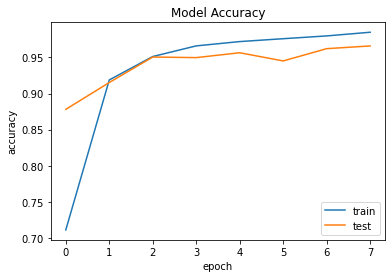

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

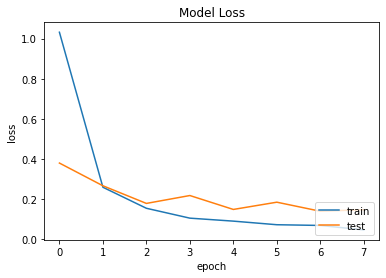

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

## Save Model

In [61]:
model.save("model-facerecognition_1.h5")

## Predict to All Test Dataset

In [62]:
y_pred=model.predict(x_test)

137/137 [==============================] - 23s 165ms/step


## Plot Confusion Matrix

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

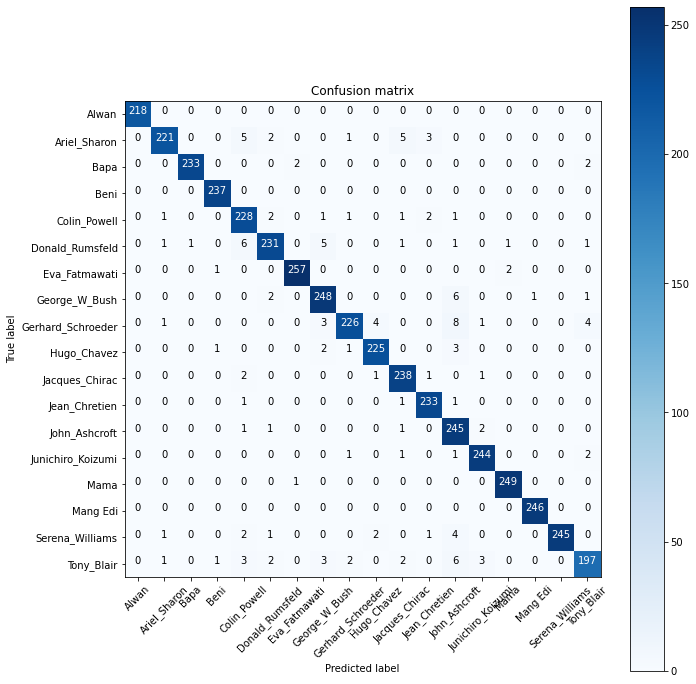

In [64]:
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=labels,normalize=False,
                      title='Confusion matrix')

In [65]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=labels))

                   precision    recall  f1-score   support

            Alwan       1.00      1.00      1.00       218
     Ariel_Sharon       0.98      0.93      0.95       237
             Bapa       1.00      0.98      0.99       237
             Beni       0.99      1.00      0.99       237
     Colin_Powell       0.92      0.96      0.94       237
  Donald_Rumsfeld       0.96      0.93      0.94       248
    Eva_Fatmawati       0.99      0.99      0.99       260
    George_W_Bush       0.95      0.96      0.95       258
Gerhard_Schroeder       0.97      0.91      0.94       247
      Hugo_Chavez       0.97      0.97      0.97       232
   Jacques_Chirac       0.95      0.98      0.97       243
    Jean_Chretien       0.97      0.99      0.98       236
    John_Ashcroft       0.89      0.98      0.93       250
Junichiro_Koizumi       0.97      0.98      0.98       249
             Mama       0.99      1.00      0.99       250
         Mang Edi       1.00      1.00      1.00       

## Apply Real-Time Face-Recognition

In [31]:
from keras.models import load_model

In [32]:
def draw_ped(img, label, x0, y0, xt, yt, color=(255,127,0), text_color=(255,255,255)):

    (w, h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv2.rectangle(img,
                  (x0, y0 + baseline),  
                  (max(xt, x0 + w), yt), 
                  color, 
                  2)
    cv2.rectangle(img,
                  (x0, y0 - h),  
                  (x0 + w, y0 + baseline), 
                  color, 
                  -1)  
    cv2.putText(img, 
                label, 
                (x0, y0),                   
                cv2.FONT_HERSHEY_SIMPLEX,     
                0.5,                          
                text_color,                
                1,
                cv2.LINE_AA) 
    return img

In [35]:
# --------- load Haar Cascade model -------------
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

# --------- load Keras CNN model -------------
model = load_model("model-facerecognition_1.h5")
print("[INFO] finish load model...")

cap = cv2.VideoCapture(0)
while cap.isOpened() :
    ret, frame = cap.read()
    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        for (x, y, w, h) in faces:
            
            face_img = gray[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (50, 50))
            face_img = face_img.reshape(1, 50, 50, 1)
            
            result = model.predict(face_img)
            idx = result.argmax(axis=1)
            confidence = result.max(axis=1)*100
            if confidence > 80:
                label_text = "%s (%.2f %%)" % (labels[idx], confidence)
            else :
                label_text = "Tidak Terdeteksi"
            frame = draw_ped(frame, label_text, x, y, x + w, y + h, color=(0,255,255), text_color=(50,50,50))
       
        cv2.imshow('Detect Face', frame)
    else :
        break
    if cv2.waitKey(10) == ord('q'):
        break
        
cv2.destroyAllWindows()
cap.release()

[INFO] finish load model...
1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 47ms/step


In [32]:
cv2.destroyAllWindows()
cap.release()